# Import the merged_data dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving merged_data.xlsx to merged_data.xlsx


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu

dataset = pd.read_excel('merged_data.xlsx')

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Datatype variables

In [5]:
dataset.dtypes.rename('datatype')

,datatype
idstore,int64
district,object
selling_square_ft,int64
type,object
sku,int64
brand,object
oldpvp,float64
new_pvp,float64
discount,float64
discount%interval,object


In [6]:
# We noticed that the data types of the variables weight (g) and period_sell_vs_labelling are set as float, and we will change them to int, even though they have missing values.
dataset['weight (g)'] = pd.to_numeric(dataset['weight (g)'], errors='coerce').astype('Int64')
dataset['period_sell_vs_labelling'] = pd.to_numeric(dataset['period_sell_vs_labelling'], errors='coerce').astype('Int64')

dataset.dtypes.rename('datatype')

,datatype
idstore,int64
district,object
selling_square_ft,int64
type,object
sku,int64
brand,object
oldpvp,float64
new_pvp,float64
discount,float64
discount%interval,object


## Missing Values Analysis

In [7]:
# Missing values per variable
missing_values = dataset.isnull().sum().rename('missing_values')
missing_values

,missing_values
idstore,0
district,0
selling_square_ft,0
type,0
sku,0
brand,0
oldpvp,0
new_pvp,0
discount,0
discount%interval,0


## Definition of Variables

In [8]:
# For our statistical study and also later for modeling, we will define all variables except the last one as features, and the last variable as the target.

# Define features (X) and target (y)
features = dataset.columns[:-1]  # All columns except the last one
target = dataset.columns[-1]     # The last column

X = dataset[features]
y = dataset[target]

# Features (X)
print("Features:", features.tolist())

# Target (y)
print("Target:", target)

Features: ['idstore', 'district', 'selling_square_ft', 'type', 'sku', 'brand', 'oldpvp', 'new_pvp', 'discount', 'discount%interval', 'labelqty', 'weight (g)', 'payment_method', 'margin (%)', 'margin%interval', 'profit (€)', 'perc_expiring_sku', 'perc_interval', 'expiring_date', 'labelling_date', 'sell_date', 'expiring_days', 'period_sell_vs_labelling', 'period_expiring_vs_labelling']
Target: sold


In [9]:
''' Analyzing the features above, we decided to remove the variables idstore and labelqty because they are not actually features. In the first case, idstore indicates the store number,
and in the second case, labelqty represents the quantity of the item (which is a constant - 1).'''

# Remove 'idstore' and 'labelqty' from features
features_to_remove = ['idstore','sku','labelqty','expiring_date','labelling_date','sell_date']
features = [feature for feature in features if feature not in features_to_remove]

X = dataset[features]

print("Features:", features)
print("Target:", target)

Features: ['district', 'selling_square_ft', 'type', 'brand', 'oldpvp', 'new_pvp', 'discount', 'discount%interval', 'weight (g)', 'payment_method', 'margin (%)', 'margin%interval', 'profit (€)', 'perc_expiring_sku', 'perc_interval', 'expiring_days', 'period_sell_vs_labelling', 'period_expiring_vs_labelling']
Target: sold


In [10]:
# Define as features_numerical the variables that have the data type int or float.

numerical_features = X.select_dtypes(include=['int', 'float']).columns.tolist()
print("numerical_features:", numerical_features)

numerical_features: ['selling_square_ft', 'oldpvp', 'new_pvp', 'discount', 'weight (g)', 'margin (%)', 'profit (€)', 'perc_expiring_sku', 'expiring_days', 'period_sell_vs_labelling', 'period_expiring_vs_labelling']


In [12]:
dataset[numerical_features].describe()

,selling_square_ft,oldpvp,new_pvp,discount,weight (g),margin (%),profit (€),perc_expiring_sku,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling
count,149221.000000,149221.000000,149221.000000,149221.000000,148797.0,149221.00000,149221.000000,149221.000000,149221.000000,80069.0,149221.000000
mean,5703.485180,1.573065,1.095615,0.302257,163.448114,15.82739,0.174481,0.384930,6.302980,0.926139,1.482050
std,5460.133613,0.569421,0.394158,0.036908,57.80621,3.30236,0.076051,0.222710,20.730896,0.831911,1.322699
min,10.000000,0.590000,0.340000,0.010000,1.0,10.00000,0.034000,0.000000,1.000000,0.0,0.000000
25%,1108.000000,1.190000,0.830000,0.300000,123.0,13.00000,0.124500,0.200000,3.000000,0.0,1.000000
50%,4641.000000,1.590000,1.110000,0.300000,166.0,17.00000,0.152900,0.333333,3.000000,1.0,1.000000
75%,8329.000000,1.890000,1.320000,0.300000,192.0,19.00000,0.222400,0.666667,5.000000,1.0,2.000000
max,25258.000000,17.990000,8.990000,0.510000,410.0,20.00000,1.438400,1.000000,359.000000,20.0,25.000000


## Data Balancing

In [13]:
# We will check at the beginning of our statistical analysis if the complete dataset is balanced, meaning if the number of observations for each value of our target (sold) is evenly distributed.

# Calculate the counts and weights for each 'sold' value
sold_counts = dataset['sold'].value_counts()
sold_weights = sold_counts / len(dataset) * 100

# Create the table with the counts and weights
sold_table = pd.DataFrame({'Count': sold_counts, 'Weight (%)': sold_weights.round(2)})

# Replace 'True' and 'False' values in the 'sold' column with 'Vendido' and 'Não Vendido'
sold_table = sold_table.rename(index={True: 'Sold', False: 'Not Sold'})  # Correctly rename index values

# Format the 'Count' column with thousand separators as dots
sold_table['Count'] = sold_table['Count'].apply(lambda x: f"{x:,.0f}".replace(",", "."))

# Change the name of the second column from 'Count' to 'Nº Observações'
sold_table.rename(columns={'Count': '# Observations'}, inplace=True)

# Remove the name of the first column (Index) and the table header
sold_table.columns.name = None  # Remove the column header name
sold_table.index.name = None  # Remove the index name (first column)

# Display the table
sold_table

,# Observations,Weight (%)
Sold,80.069,53.66
Not Sold,69.152,46.34


## Outliers Analysis

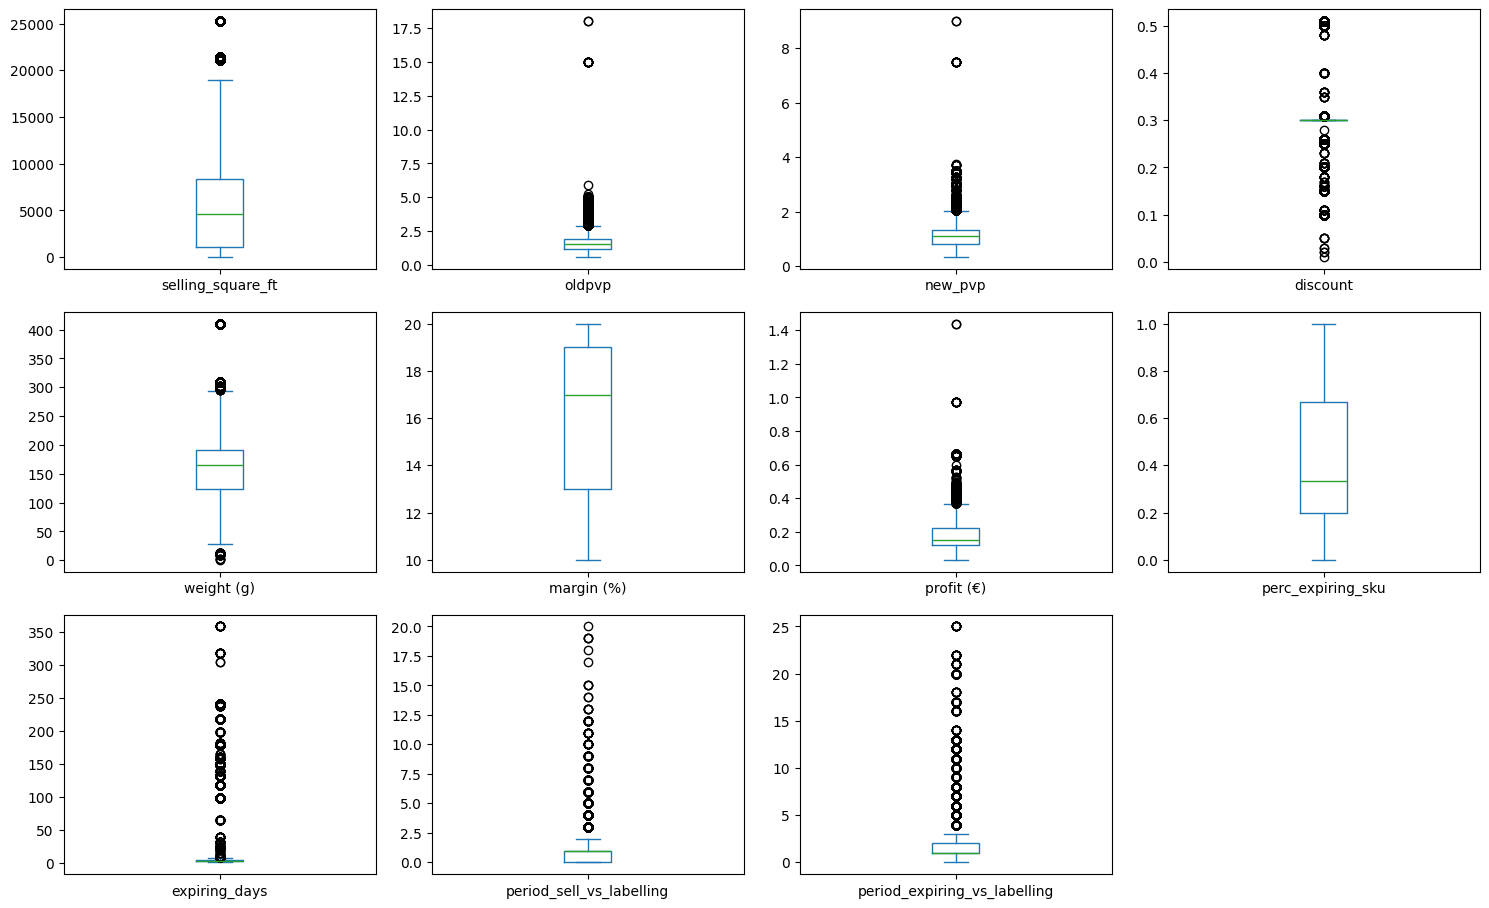

In [14]:
# We will analyze the variability of the data by creating boxplots for the feature variables that have a numeric data type, meaning float and int.

# Identify the variables for which we will create boxplots
columns_to_plot = [col for col in numerical_features]

# The 'whis' parameter defines the factor for the interquartile range (default is 1.5).
dataset[columns_to_plot].plot(kind='box',
                              subplots=True,
                              layout=(5, 4),
                              figsize=(15, 15),
                              whis=1.5)

plt.tight_layout()  # Avoid label overlap
plt.show()

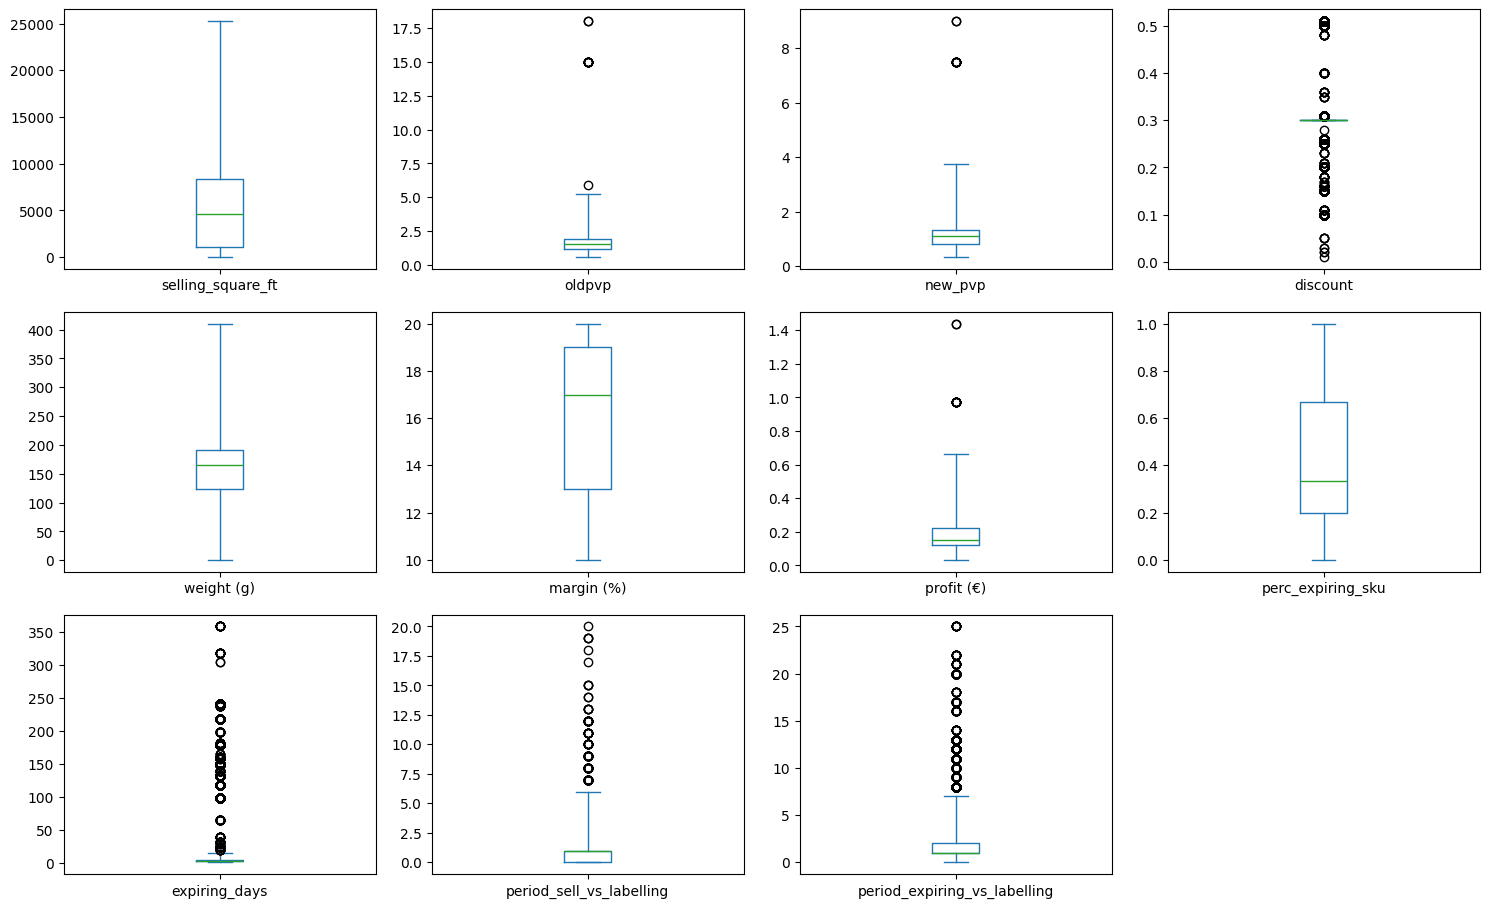

In [17]:
# Given the results above, with the data dispersion across various features, we chose to change the multiplier associated with the interquartile range to 5

# Identify the variables for which we will create boxplots
columns_to_plot = [col for col in numerical_features]

# The 'whis' parameter defines the factor for the interquartile range (default is 1.5). We will change it to 5.
dataset[columns_to_plot].plot(kind='box',
                              subplots=True,
                              layout=(5, 4),
                              figsize=(15, 15),
                              whis=5)  # Adjust the interquartile range (IQR) to 5

plt.tight_layout()  # Avoid label overlap
plt.show()

In [19]:
# Given the interquartile range of each feature with the data type int and float, we will define the values from which we can identify the presence of outliers and also determine how many outliers exist for each feature under analysis.

# Create the list to store the information
outlier_info = []

# Analyze the numeric features
for col in numerical_features:
    # Calculate the IQR and the bounds
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 5 * IQR
    upper_bound = Q3 + 5 * IQR

    # Calculate the number of lower and upper outliers
    lower_outliers = dataset[dataset[col] < lower_bound].shape[0]
    upper_outliers = dataset[dataset[col] > upper_bound].shape[0]

    # Round the bounds to 2 decimal places
    lower_bound = round(lower_bound, 2)
    upper_bound = round(upper_bound, 2)

    # Format the outliers with thousand separators
    lower_outliers_formatted = f'{lower_outliers:,}'.replace(',', '.')
    upper_outliers_formatted = f'{upper_outliers:,}'.replace(',', '.')

    # Add the information to the list
    outlier_info.append([col, lower_bound, upper_bound, lower_outliers_formatted, upper_outliers_formatted])

# Create the DataFrame with the 5 columns
outlier_dataset = pd.DataFrame(outlier_info, columns=['Feature', 'Lower Limit', 'Upper Limit', 'Lower Outliers', 'Upper Outliers'])

# Display the resulting table
outlier_dataset

,Feature,Lower Limit,Upper Limit,Lower Outliers,Upper Outliers
0,selling_square_ft,-34997.00,44434.00,0,0
1,oldpvp,-2.31,5.39,0,14
2,new_pvp,-1.62,3.77,0,13
3,discount,0.30,0.30,6.951,12.300
4,weight (g),-222.00,537.00,0,0
5,margin (%),-17.00,49.00,0,0
6,profit (€),-0.36,0.71,0,13
7,perc_expiring_sku,-2.13,3.00,0,0
8,expiring_days,-7.00,15.00,0,2.485
9,period_sell_vs_labelling,-5.00,6.00,0,167


## Analysis of the distribution of numerical_features

In [20]:
print("The Kernel Density Estimate (KDE) generates a smooth estimate of the distribution, which helps visualize underlying trends without the granularity of a histogram..\n"
      "Thus, the KDE, through a smooth curve, allows a better visualization of the data distribution shape as it does not depend on bins (intervals).\n"
      "Instead, the smoothness is determined by the kernel and its bandwidth, offering greater flexibility in how the distribution is modeled.\n"
      "\n"
      "A KDE plot is useful for\n"
      "- Visualizing distributions: It allows us to observe the distribution of continuous data\n"
      "- Exploratory analysis: A common procedure in initial data analysis, used to understand the data distribution.")

The Kernel Density Estimate (KDE) generates a smooth estimate of the distribution, which helps visualize underlying trends without the granularity of a histogram..
Thus, the KDE, through a smooth curve, allows a better visualization of the data distribution shape as it does not depend on bins (intervals).
Instead, the smoothness is determined by the kernel and its bandwidth, offering greater flexibility in how the distribution is modeled.

A KDE plot is useful for
- Visualizing distributions: It allows us to observe the distribution of continuous data
- Exploratory analysis: A common procedure in initial data analysis, used to understand the data distribution.


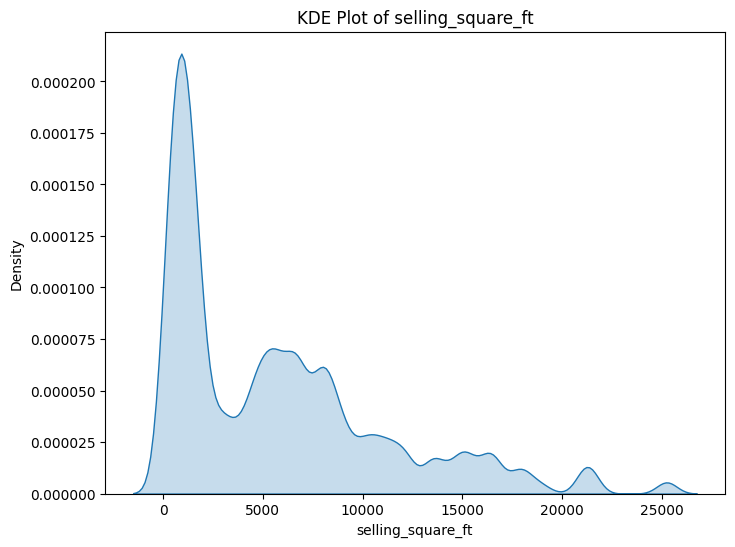

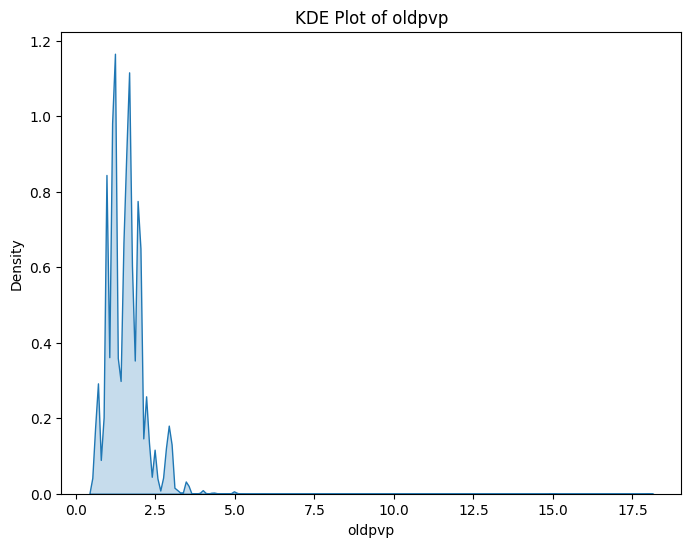

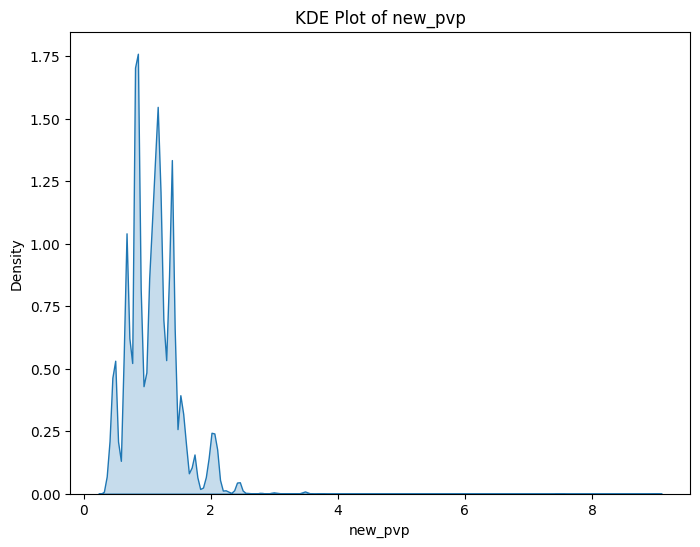

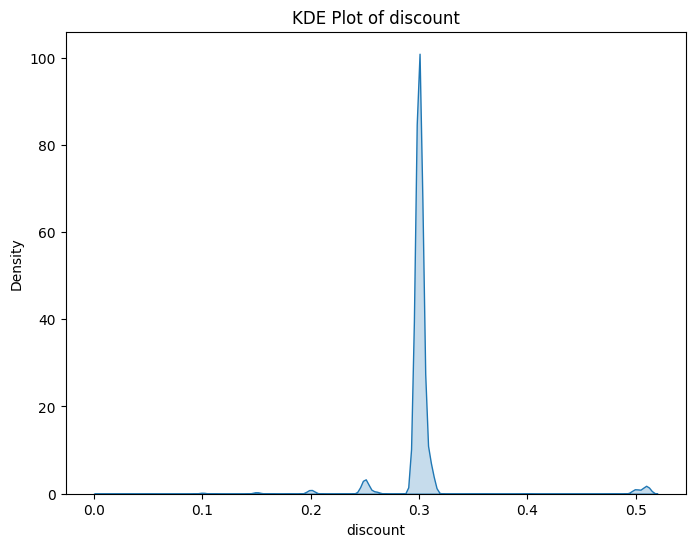

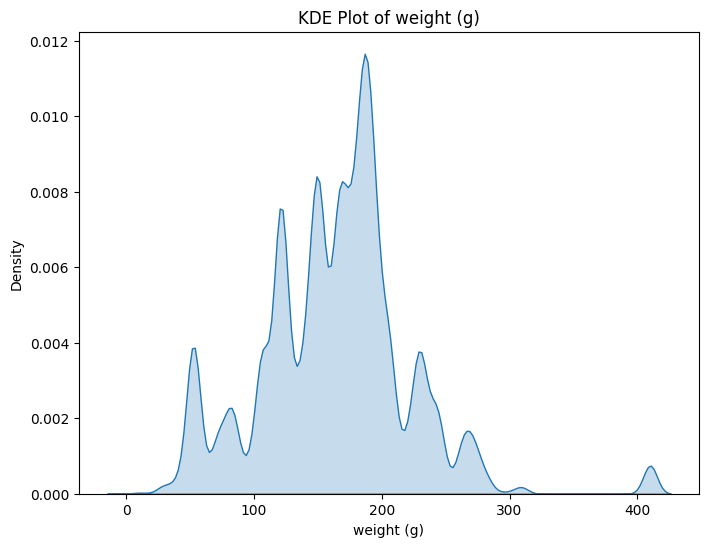

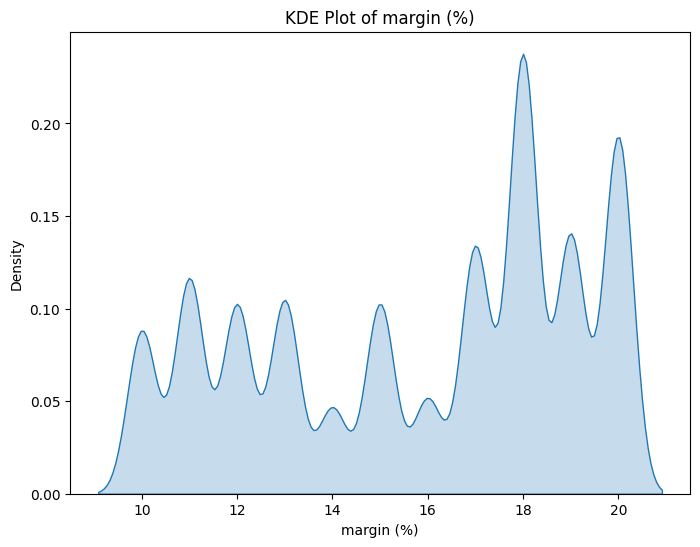

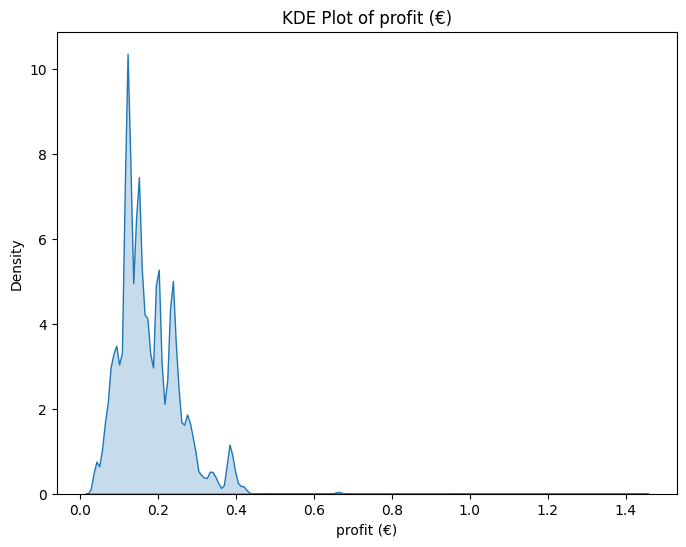

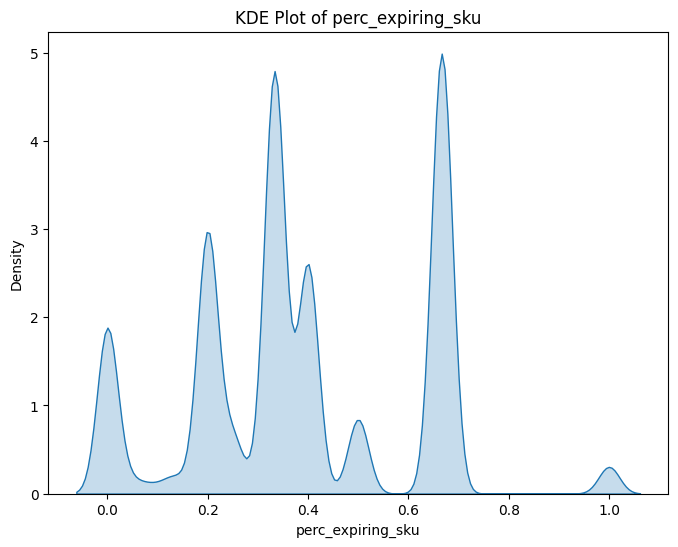

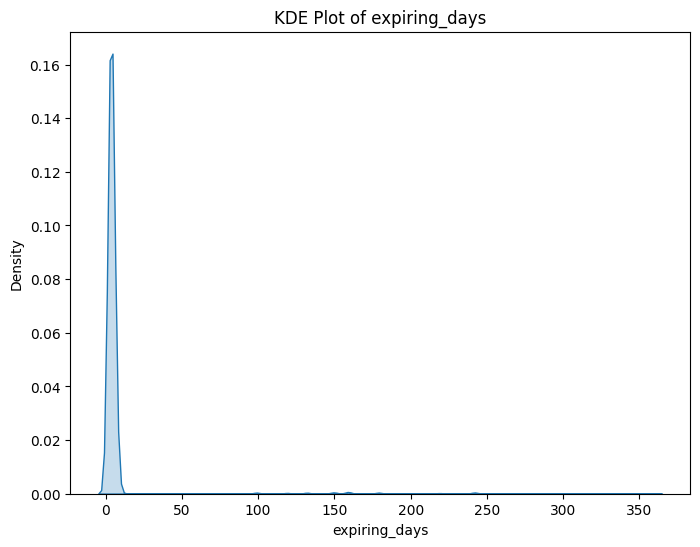

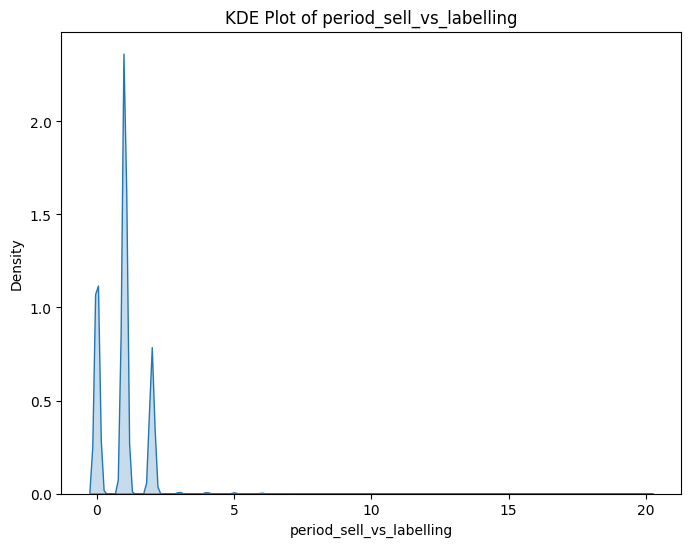

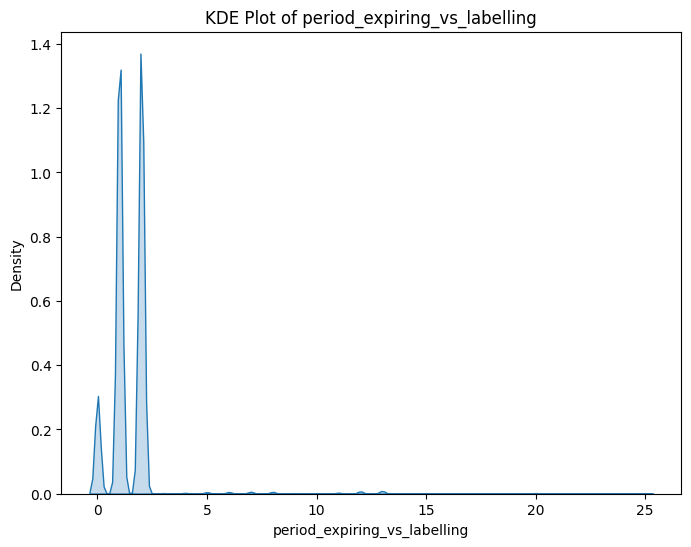

In [21]:
# Considering the nature of the variables, we will create a KDE plot for each of the numerical variables.

for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(dataset[feature], shade=True)
    plt.title(f'KDE Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

## Analysis of Store Revenue by District

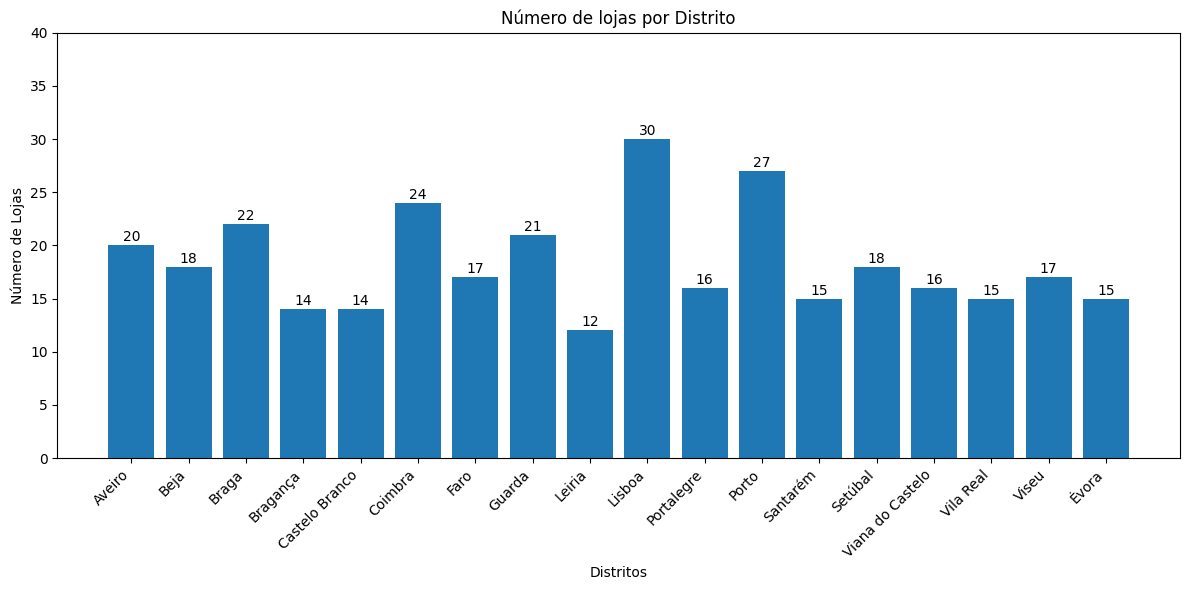

In [22]:
# We will first analyze the number of stores per district to understand if there is a significant discrepancy in the number of stores across districts in our data.

# Count distinct idstores per district
idstore_counts = dataset.groupby('district')['idstore'].nunique()

# Create the barplot
plt.figure(figsize=(12, 6))
bars = plt.bar(idstore_counts.index, idstore_counts.values)

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (the count)
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1,  # Position the label above the bar
             str(int(yval)), ha='center', va='bottom', fontsize=10)  # Add the label

# Labels and title
plt.xlabel('Distritos')
plt.ylabel('Número de Lojas')
plt.title('Número de lojas por Distrito')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the Y-axis limit
plt.ylim(0, 40)  # Set the max Y-axis limit to 40

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

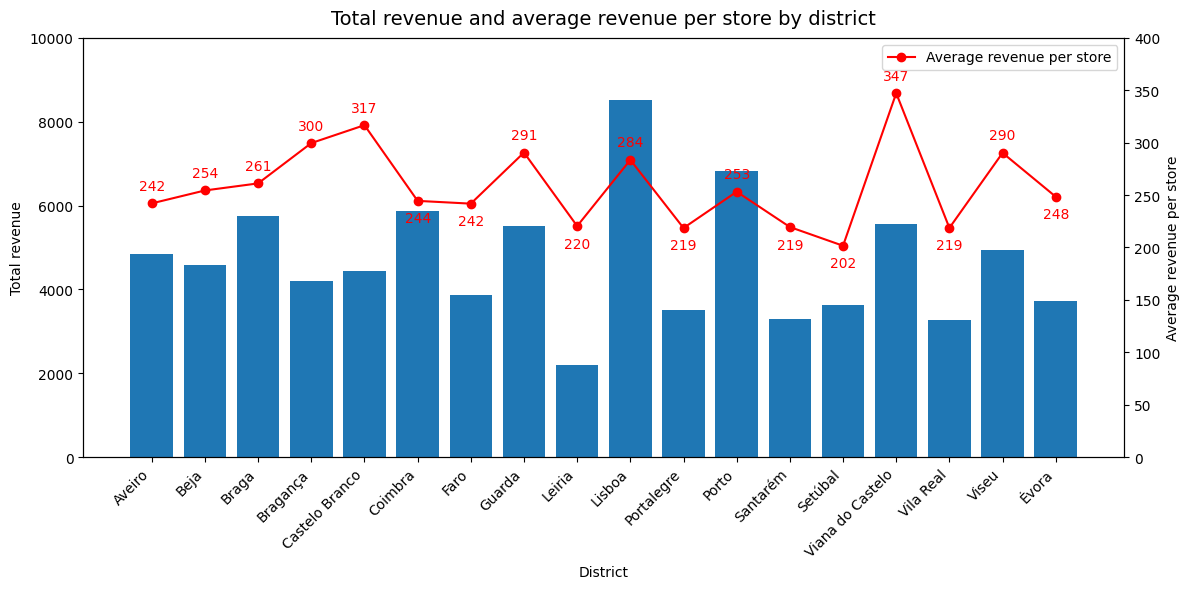

In [23]:
# To better understand the revenue behavior by district, and because districts with larger populations will naturally have higher revenue, we will analyze the actual revenue behavior per district per store.

# To group the data by district and sum the new_pvp when sold == 1
district_sales = dataset[dataset['sold'] == 1].groupby('district')['new_pvp'].sum()

# Calculate the number of distinct stores per district, considering only when sold == 1.
distinct_stores_per_district = dataset[dataset['sold'] == 1].groupby('district')['idstore'].nunique()

# Calculate the average of new_pvp per store for each district, considering only when sold == 1
average_new_pvp_per_store = district_sales / distinct_stores_per_district

# Create a graph with multiple y-axes.
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart with the specified color
bars = ax1.bar(district_sales.index, district_sales.values, color=(31/255, 119/255, 180/255))

# Customize the chart
ax1.set_xlabel('District')
ax1.set_ylabel('Total revenue', color='black')

# Setting the ticks before defining the tick labels.
ax1.set_xticks(range(len(district_sales)))

# Define the tick labels.
ax1.set_xticklabels(district_sales.index, rotation=45, ha='right')

# Set the y-axis limits from 0 to 10,000 in a chart
ax1.set_ylim(0, 10000)

# Create the second y-axis for the line chart.
ax2 = ax1.twinx()

# Line chart (average of new_pvp per store)
line, = ax2.plot(average_new_pvp_per_store.index, average_new_pvp_per_store.values, color='red', marker='o', linestyle='-', label='Average revenue per store')

# Setting the second y-axis.
ax2.set_ylabel('Average revenue per store', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 400)
ax2.set_yticks(range(0, 401, 50))

# Add data labels to the line (average of new_pvp per store) with specific rules:
for i, v in enumerate(average_new_pvp_per_store.values):
    if i > 0:
        if v > average_new_pvp_per_store.values[i-1]:
            ax2.text(i, v + 10, f'{v:.0f}', ha='center', va='bottom', color='red', fontsize=10)
        else:
            ax2.text(i, v - 10, f'{v:.0f}', ha='center', va='top', color='red', fontsize=10)
    else:
        ax2.text(i, v + 10, f'{v:.0f}', ha='center', va='bottom', color='red', fontsize=10)

# Add the line legend with the new text
ax2.legend(loc='upper right')

# Adjust the title
plt.title('Total revenue and average revenue per store by district', fontsize=14, pad=10)

# Adjust the layout to avoid overlap
plt.tight_layout()

# Display the chart
plt.show()

## Analysis of the discount value by store type

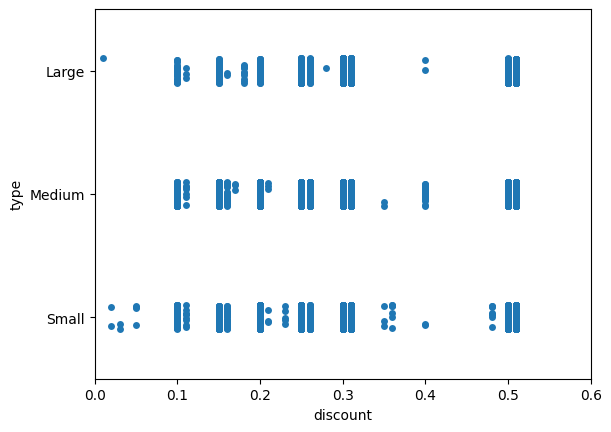

In [ ]:
sns.stripplot(data=dataset, x="discount", y="type", jitter=True)
plt.xlabel("discount")
plt.ylabel("type")

# Set the x-axis limit to 0.6
plt.xlim(0, 0.6)

plt.show()

## Analysis of Sold Items and Distinct SKUs by Brand

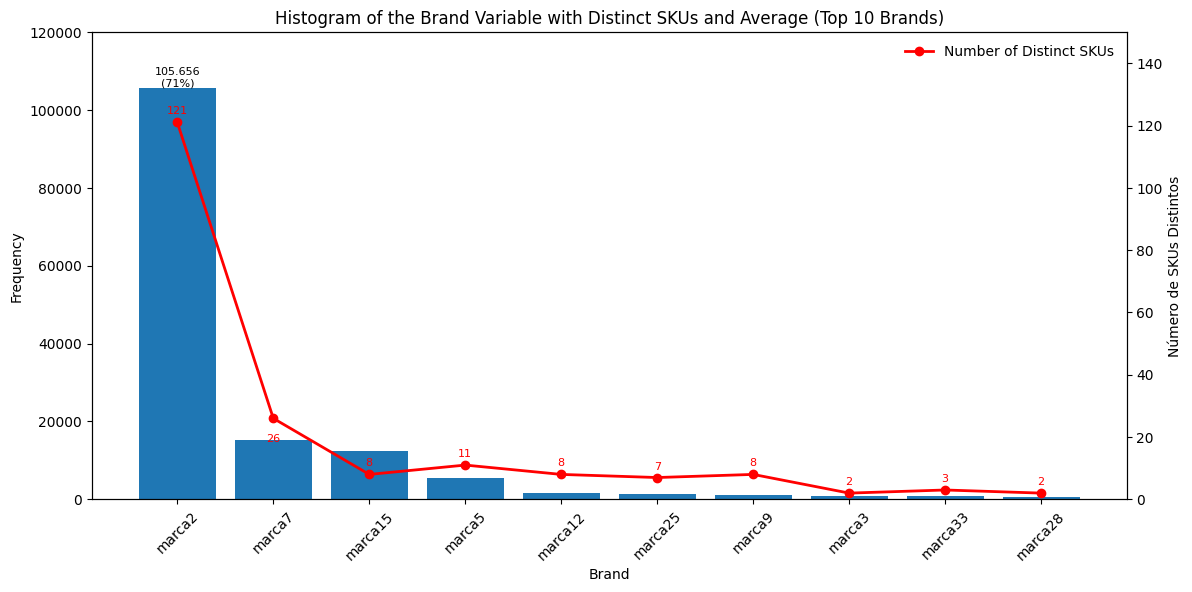

In [ ]:
# Through the histogram chart, we will analyze the distribution of the data for the 'brand' variable
brand_counts = dataset['brand'].value_counts()

# Get the top 10 brands
top_10_brands = brand_counts.head(10)

# Create a new DataFrame for the histogram considering only the top 10 brands
histogram_data = pd.DataFrame({
    'brand': top_10_brands.index.tolist(),
    'frequency': top_10_brands.values.tolist()
})

# Total number of observations in the dataset
total_observations = len(dataset)

# Calculate the number of distinct SKUs per brand.
unique_skus = dataset.groupby('brand')['sku'].nunique()

# Filter only the top 10 brands
unique_skus_top10 = unique_skus.loc[top_10_brands.index]

# Create the chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Frequency histogram (primary y-axis)
bars = ax1.bar(histogram_data['brand'], histogram_data['frequency'], label='Frequency')
ax1.set_xlabel("Brand")
ax1.set_ylabel("Frequency", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Add data labels above each bar (only for "marca2")
for i, bar in enumerate(bars):
    yval = bar.get_height()
    yval_formatted = f'{int(yval):,}'.replace(',', '.')

    # Calculate the percentage of total observations
    percentage = (yval / total_observations) * 100
    percentage_formatted = f'{percentage:.0f}%'

    # Show the label only for "marca2"
    if histogram_data['brand'][i] == 'marca2':
        label = f'{int(yval):,}'.replace(',', '.') + f'\n({percentage_formatted})'
        ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.1 , label, ha='center', va='bottom', fontsize=8)

# Create the second y-axis
ax2 = ax1.twinx()

# Line for the number of distinct SKUs (secondary y-axis)
line, = ax2.plot(histogram_data['brand'], unique_skus_top10.values, color='red', marker='o', label='Number of Distinct SKUs', linestyle='-', linewidth=2)

# Add data labels on the line (labels for the line points) in red
for i, value in enumerate(unique_skus_top10.values):
    label = f'{int(value):,}'.replace(',', '.')

    # For brand 7, the label should be placed below the line
    if histogram_data['brand'][i] == 'marca7':
        ax2.text(i, value - 5, label, ha='center', va='top', fontsize=8, color='red')
    else:
        ax2.text(i, value + 2, label, ha='center', va='bottom', fontsize=8, color='red')

# Adjust the maximum limit of the secondary y-axis (number of distinct SKUs)
ax2.set_ylim(0, 150)

# Changed to 'black' in the title of the secondary y-axis
ax2.set_ylabel("Número de SKUs Distintos", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adjust the maximum limit of the primary y-axis (frequency) to 120,000
ax1.set_ylim(0, 120000)

# Add a legend to the chart, with the legend in the top-right corner.
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False)

# Title
plt.title("Histogram of the Brand Variable with Distinct SKUs and Average (Top 10 Brands)")

# Explicitly set the ticks before defining the labels
ax1.set_xticks(range(len(histogram_data['brand'])))

# Defining the tick labels
ax1.set_xticklabels(histogram_data['brand'], rotation=45, ha='center')

# Adjust the layout to minimize the spacing from the top.
plt.tight_layout(pad=1.0)

plt.show()

## Normalization test of the numerical_features

In [24]:
''' For each of the numerical features in the dataset, we will perform the Kolmogorov-Smirnov test in order to analyze the data distribution behavior.
However, since there are missing values in the variables, we will only consider the available data (without missing values) to perform the test.'''


for feature in numerical_features:
    # Exclude the variable 'period_sell_vs_labelling'
    if feature == 'period_sell_vs_labelling':
        continue

    # Remove missing values for the current feature
    clean_data = dataset[feature].dropna()

    # Perform the Kolmogorov-Smirnov test for normality
    # Comparing the data with a standard normal distribution (mean=0, standard deviation=1)
    ks_test = stats.kstest(clean_data, 'norm')

    # Display the test results
    print(f"Kolmogorov-Smirnov Test Results for {feature}:")
    print(f"Statistic: {ks_test.statistic:.5f}")
    print(f"P-value: {ks_test.pvalue:.5f}")  # Rounding the p-value to 5 decimal places

    # Interpret the results
    alpha = 0.05  # Significance level
    if ks_test.pvalue > alpha:
        print(f"The data in {feature} is likely normally distributed.")
    else:
        print(f"The data in {feature} is likely not normally distributed.")
    print("-" * 100)  # Separator for clarity

Kolmogorov-Smirnov Test Results for selling_square_ft:
Statistic: 1.00000
P-value: 0.00000
The data in selling_square_ft is likely not normally distributed.
----------------------------------------------------------------------------------------------------
Kolmogorov-Smirnov Test Results for oldpvp:
Statistic: 0.77484
P-value: 0.00000
The data in oldpvp is likely not normally distributed.
----------------------------------------------------------------------------------------------------
Kolmogorov-Smirnov Test Results for new_pvp:
Statistic: 0.67531
P-value: 0.00000
The data in new_pvp is likely not normally distributed.
----------------------------------------------------------------------------------------------------
Kolmogorov-Smirnov Test Results for discount:
Statistic: 0.58512
P-value: 0.00000
The data in discount is likely not normally distributed.
----------------------------------------------------------------------------------------------------
Kolmogorov-Smirnov Test Resu

## Hypothesis test on the distribution of data for the numerical_features variables by sold vs. not sold items.

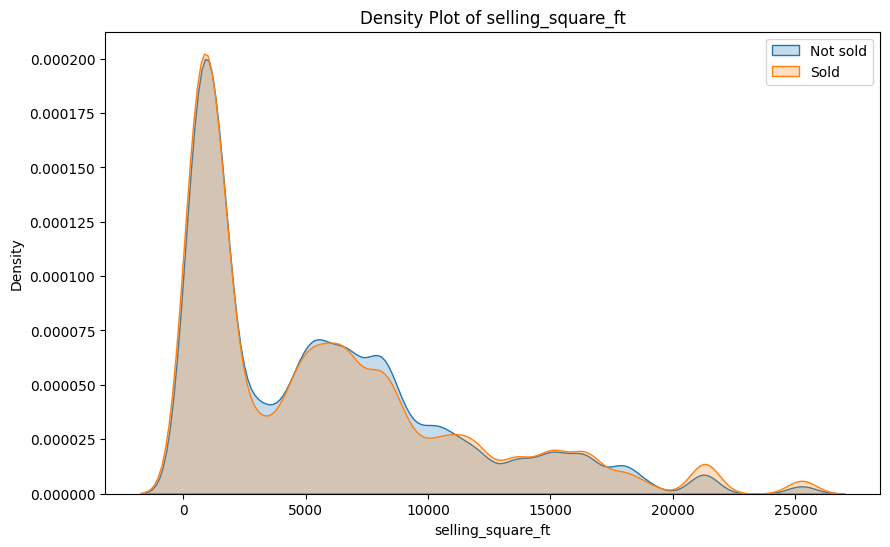

Mann-Whitney U Test Results for selling_square_ft:
Statistic: 2793102206.00000
P-value: 0.00299
The difference in the data distribution of the variable 'selling_square_ft' between the sold items group and the unsold items group is statistically significant.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


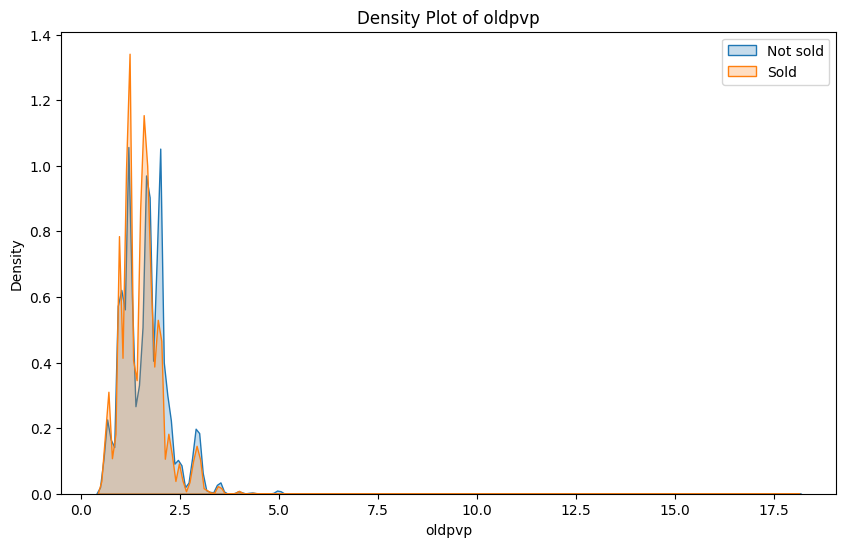

Mann-Whitney U Test Results for oldpvp:
Statistic: 3142361916.50000
P-value: 0.00000
The difference in the data distribution of the variable 'oldpvp' between the sold items group and the unsold items group is statistically significant.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


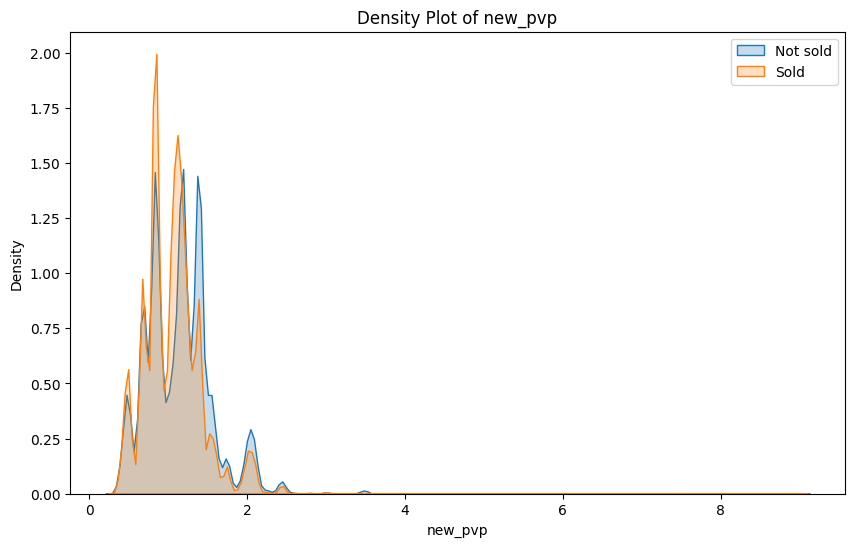

Mann-Whitney U Test Results for new_pvp:
Statistic: 3142859653.00000
P-value: 0.00000
The difference in the data distribution of the variable 'new_pvp' between the sold items group and the unsold items group is statistically significant.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


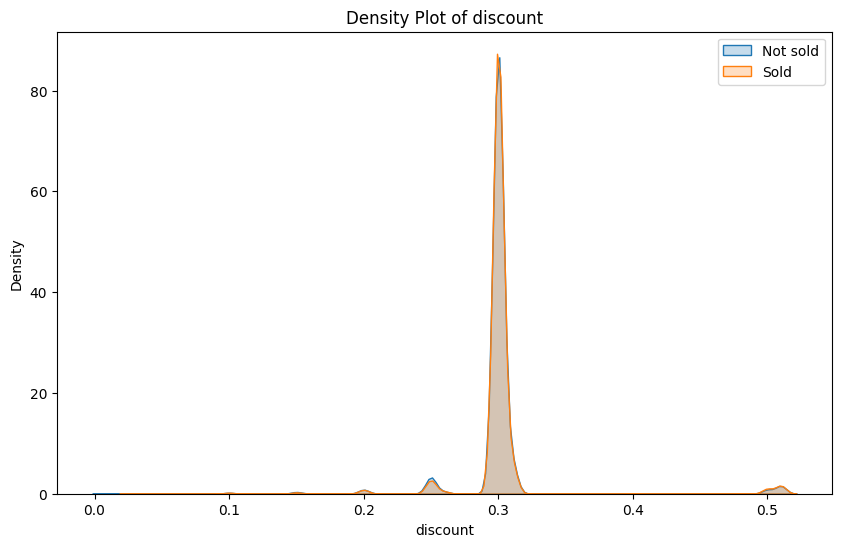

Mann-Whitney U Test Results for discount:
Statistic: 2752257081.00000
P-value: 0.00079
The difference in the data distribution of the variable 'discount' between the sold items group and the unsold items group is statistically significant.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


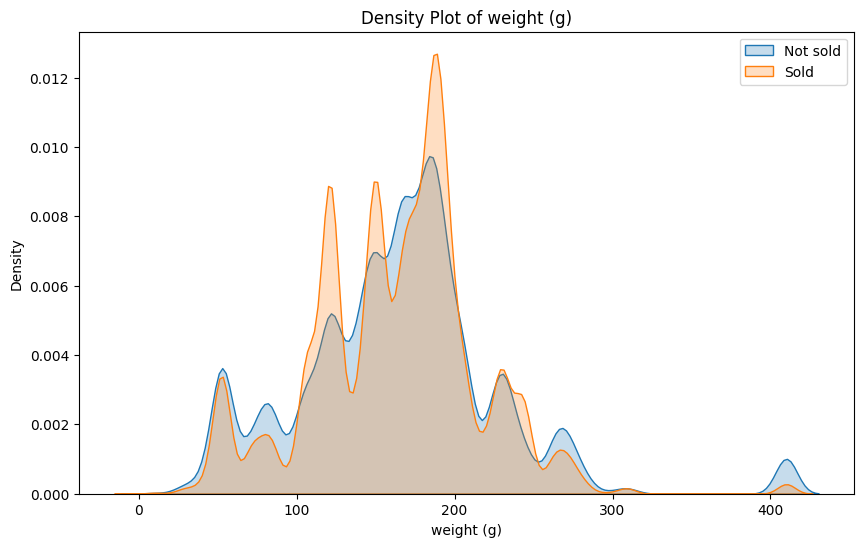

Mann-Whitney U Test Results for weight (g):
Statistic: 2732959917.50000
P-value: 0.01866
The difference in the data distribution of the variable 'weight (g)' between the sold items group and the unsold items group is statistically significant.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


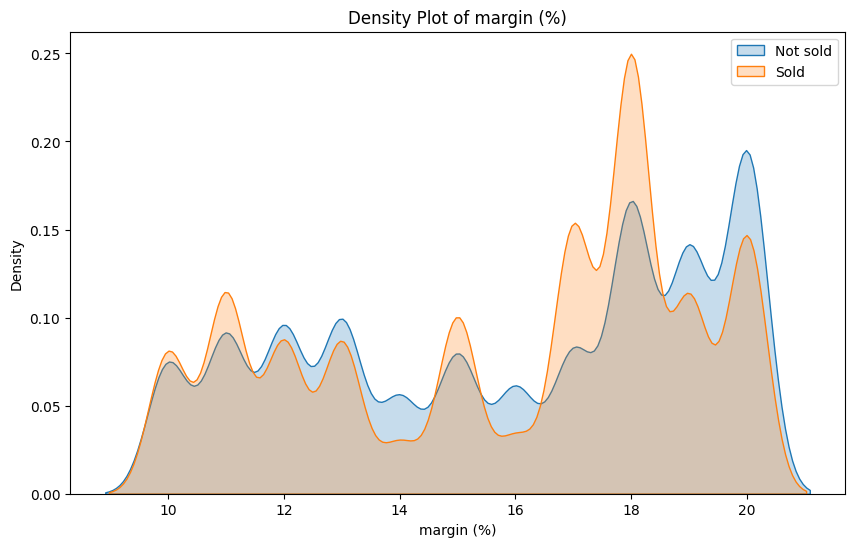

Mann-Whitney U Test Results for margin (%):
Statistic: 2856426533.00000
P-value: 0.00000
The difference in the data distribution of the variable 'margin (%)' between the sold items group and the unsold items group is statistically significant.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


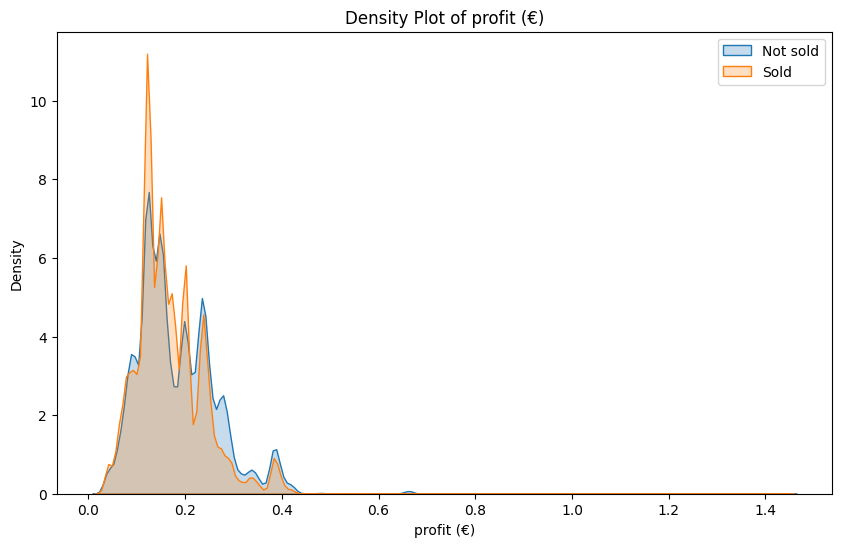

Mann-Whitney U Test Results for profit (€):
Statistic: 3031925031.00000
P-value: 0.00000
The difference in the data distribution of the variable 'profit (€)' between the sold items group and the unsold items group is statistically significant.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


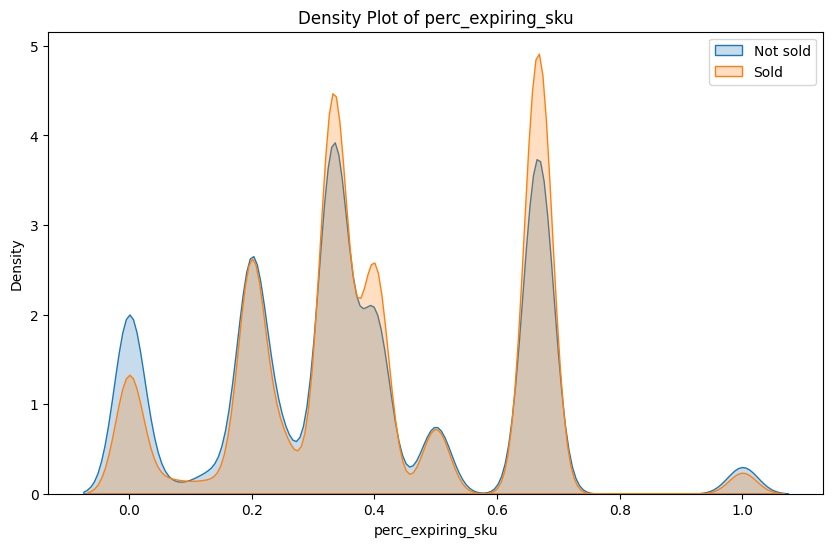

Mann-Whitney U Test Results for perc_expiring_sku:
Statistic: 2533809061.00000
P-value: 0.00000
The difference in the data distribution of the variable 'perc_expiring_sku' between the sold items group and the unsold items group is statistically significant.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


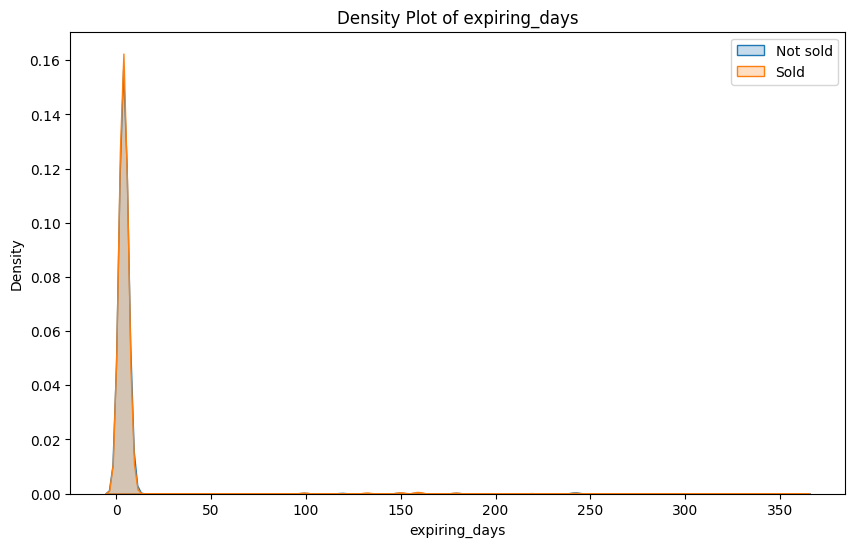

Mann-Whitney U Test Results for expiring_days:
Statistic: 2803837982.50000
P-value: 0.00000
The difference in the data distribution of the variable 'expiring_days' between the sold items group and the unsold items group is statistically significant.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


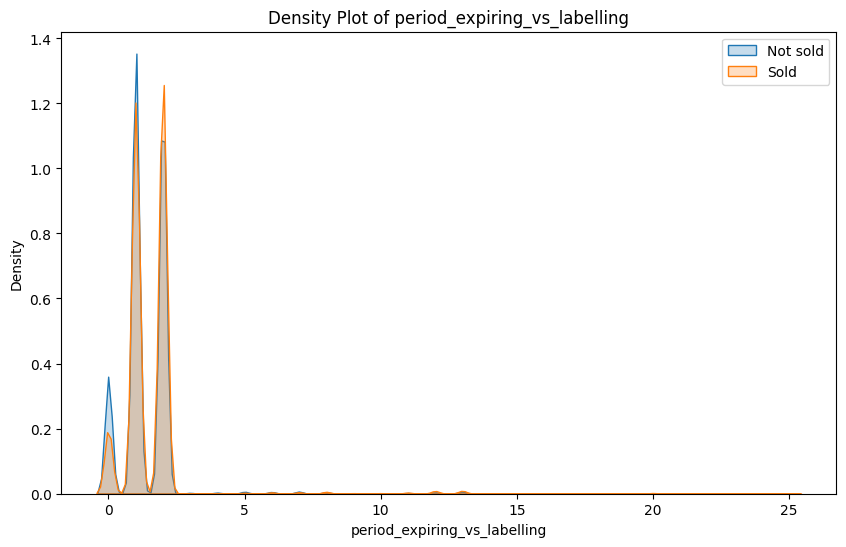

Mann-Whitney U Test Results for period_expiring_vs_labelling:
Statistic: 2528673951.00000
P-value: 0.00000
The difference in the data distribution of the variable 'period_expiring_vs_labelling' between the sold items group and the unsold items group is statistically significant.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Variables whose differences in data distribution are statistically significant between sold and unsold items:
['selling_square_ft', 'oldpvp', 'new_pvp', 'discount', 'weight (g)', 'margin (%)', 'profit (€)', 'perc_expiring_sku', 'expiring_days', 'period_expiring_vs_labelling']


In [26]:
# In order to understand if the data distribution behaviors for each of the numerical features are different depending on whether we are analyzing sold or unsold items, we will perform a hypothesis test.

# List to store the significant features
significant_features = []

# Iterate over the numerical features
for feature in numerical_features:
    # Excluir a variável 'period_sell_vs_labelling'
    if feature == 'period_sell_vs_labelling':
        continue

    # Remove missing values for the current feature and 'sold'
    clean_data = dataset[[feature, 'sold']].dropna(subset=[feature, 'sold'])

    # Check if there is enough data after removing the missing values
    if len(clean_data) < 2:
        print(f"Not enough data for feature {feature} after removing missing values.")
        continue

    # Plot the density graphs for the clean data
    plt.figure(figsize=(10, 6))
    sns.kdeplot(clean_data[clean_data['sold'] == 0][feature], label='Not sold', shade=True)
    sns.kdeplot(clean_data[clean_data['sold'] == 1][feature], label='Sold', shade=True)

    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Density Plot of {feature}')
    plt.legend()
    plt.show()

    # Perform the Mann-Whitney U test to compare the 'sold = 0' and 'sold = 1' groups for the variable
    group1 = clean_data[clean_data['sold'] == 0][feature]
    group2 = clean_data[clean_data['sold'] == 1][feature]

    # Check if both groups have enough data before performing the test
    if len(group1) > 0 and len(group2) > 0:
        # Mann-Whitney U Test
        statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

        # Display the results of the test
        print(f"Mann-Whitney U Test Results for {feature}:")
        print(f"Statistic: {statistic:.5f}")
        print(f"P-value: {p_value:.5f}")

        # Interpret the results
        alpha = 0.05  # Significance level
        if p_value < alpha:
            print(f"The difference in the data distribution of the variable '{feature}' between the sold items group and the unsold items group is statistically significant.")
            significant_features.append(feature)  # Add the feature to the list of significant ones
        else:
            print(f"The difference in the data distribution of the variable '{feature}' between the sold items group and the unsold items group is not statistically significant.")
    else:
        print(f"There is not enough data to perform the Mann-Whitney U test for the variable {feature}.")

    print("-" * 200)  # Separator for clarity

# Display the significant features
print("\nVariables whose differences in data distribution are statistically significant between sold and unsold items:")
print(significant_features)